In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display

In [27]:
# raw_data1 = pd.read_csv('data\ods032.csv', delimiter=';', parse_dates=['Datetime'], index_col='Datetime')
raw_data2 = pd.read_csv('data\ods032.csv', delimiter=';')

In [109]:
data = raw_data2.copy()
data = data[data.Region == "Belgium"]
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
data = data[['Datetime','Measured & Upscaled']]
data = data.rename(columns={'Measured & Upscaled':'generation'})
data.set_index("Datetime", inplace=True)
data = data.sort_index()
data = data['2019-01-01':'2023-12-31']
data = data.ffill().bfill()
# data = data['generation'].values.reshape(-1, 1)
data['day_of_year'] = data.index.dayofyear / 365.0
data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)
data_prescaled = data.copy()
data

,generation,day_of_year,hour_sin,hour_cos
Datetime,,,,
2019-01-01 00:00:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:15:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:30:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:45:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 01:00:00+00:00,0.0,0.00274,0.258819,0.965926
...,...,...,...,...
2023-12-31 22:45:00+00:00,0.0,1.00000,-0.500000,0.866025
2023-12-31 23:00:00+00:00,0.0,1.00000,-0.258819,0.965926
2023-12-31 23:15:00+00:00,0.0,1.00000,-0.258819,0.965926


<Axes: xlabel='Datetime', ylabel='generation'>

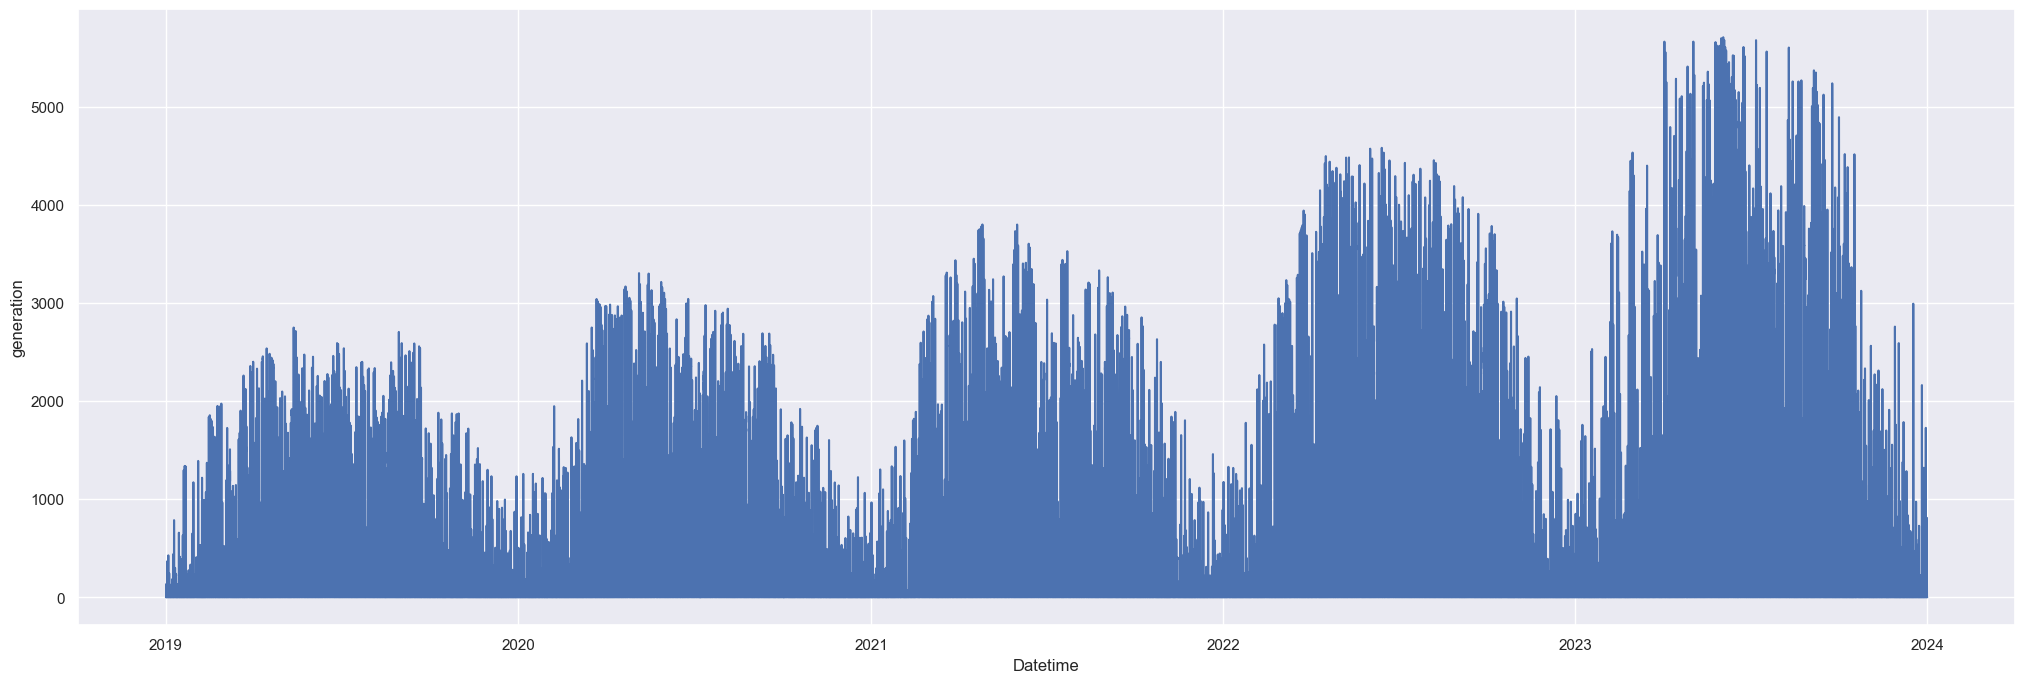

In [151]:
plt.figure(figsize=(25,8))
sns.lineplot(data.generation)

In [ ]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
data['generation'] = scaler.fit_transform(data[['generation']])

data = data[['generation', 'day_of_year', 'hour_sin', 'hour_cos']]

# Set sequence length (e.g., 96 timesteps = past 24 hours)
seq_len = 96

# Create sequences and labels
X, y = [], []
for i in range(seq_len, len(data)):
    X.append(data.iloc[i-seq_len:i].values)  # Collect past seq_len values for all features
    y.append(data.iloc[i]['generation'])     # Target is the 'generation' value at each time step

X, y = np.array(X), np.array(y)  # Convert to numpy arrays

In [98]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),  # X.shape[2] is now the number of features (e.g., 4)
    LSTM(50),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [99]:
# history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)
history = model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
2190/2190 [==============================] - 77s 34ms/step - loss: 4.4883e-04 - val_loss: 2.4800e-04
Epoch 2/5
2190/2190 [==============================] - 73s 33ms/step - loss: 5.6283e-05 - val_loss: 7.8704e-05
Epoch 3/5
2190/2190 [==============================] - 72s 33ms/step - loss: 4.6484e-05 - val_loss: 6.9469e-05
Epoch 4/5
2190/2190 [==============================] - 72s 33ms/step - loss: 4.1707e-05 - val_loss: 7.6192e-05
Epoch 5/5
2190/2190 [==============================] - 73s 33ms/step - loss: 4.0039e-05 - val_loss: 7.2909e-05


In [149]:
# Get last sequence with all features
last_sequence = data[-seq_len:].values  # Now includes all features
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))  # Reshape to (1, seq_len, num_features)

# Predict the next 7 days (672 timesteps)

days_to_predict = 30
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in range(days_to_predict*samples_per_day):
    print(f'\n{i+1} / {values_to_predict}')
    predicted_value = model.predict(last_sequence)
    predicted_values.append(predicted_value[0, 0])  # Store the predicted 'generation' value
    
    # Create a new row for the next timestep with the predicted generation value
    # Update time-based features
    next_day_of_year = ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)

    # Combine all features for the new sequence step
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos]])
    
    # Update last_sequence with the new step
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, last_sequence.shape[2]), axis=1)

# Inverse transform the predicted values for generation
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))


1 / 2880
1/1 [==============================] - 0s 28ms/step

2 / 2880
1/1 [==============================] - 0s 29ms/step

3 / 2880
1/1 [==============================] - 0s 32ms/step

4 / 2880
1/1 [==============================] - 0s 35ms/step

5 / 2880
1/1 [==============================] - 0s 34ms/step

6 / 2880
1/1 [==============================] - 0s 37ms/step

7 / 2880
1/1 [==============================] - 0s 39ms/step

8 / 2880
1/1 [==============================] - 0s 36ms/step

9 / 2880
1/1 [==============================] - 0s 38ms/step

10 / 2880
1/1 [==============================] - 0s 33ms/step

11 / 2880
1/1 [==============================] - 0s 27ms/step

12 / 2880
1/1 [==============================] - 0s 28ms/step

13 / 2880
1/1 [==============================] - 0s 28ms/step

14 / 2880
1/1 [==============================] - 0s 31ms/step

15 / 2880
1/1 [==============================] - 0s 34ms/step

16 / 2880
1/1 [==============================] - 0s 31ms/step



In [139]:
predicted_values_bak = predicted_values.copy()

In [145]:
predicted_values = predicted_values_bak.copy()

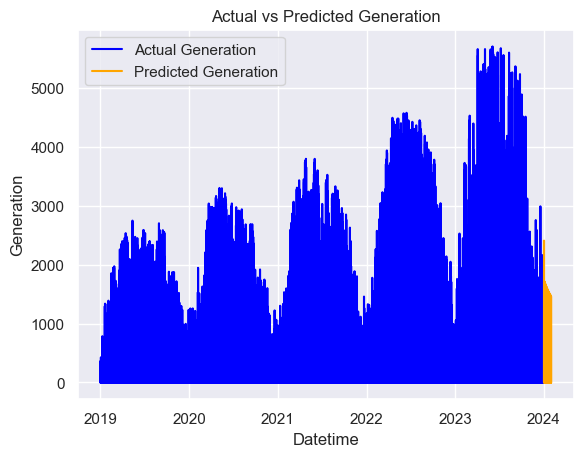

In [152]:
# Plot actual generation data
sns.lineplot(data=data_prescaled.generation[:], label='Actual Generation', color='blue')

predicted_values = np.maximum(predicted_values, 0)

# Plot predicted values
# Create a new index for predicted values to follow the last date of the actual data
predicted_index = pd.date_range(start=data.index[-1] + pd.Timedelta(minutes=15), periods=len(predicted_values), freq='15min')
sns.lineplot(x=predicted_index, y=predicted_values.flatten(), label='Predicted Generation', color='orange')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Generation')
plt.title('Actual vs Predicted Generation')
plt.legend()
plt.show()